In [ ]:
# %%

# Use Google Colab
use_google_colab = False
# Process the training dataset
training_data_processing = False
# Train the model
model_training = True
# Validation the model
model_validation = True
# Load the model from your Google Drive or local file system
model_loading = False

import numpy as np
import torch

from util.cuda import cuda
from util.gpu_info import gpuInfo
from util.data_augmentation import training_data_loading, training_data_augmentation
from util.loss import BCEIoULoss
from util.training import train
from util.testing import submission_creating, test

from networks.LinkNetB7 import *
from networks.DLinkNet34 import *
from networks.DLinkNet50 import *
from networks.DLinkNet101 import *
from networks.LinkNet34 import *
from networks.UNet import *


path_training = "./training/"
path_testing = "./test/"
path_data = "./data/"
path_model = "./models/DLinkNet34.model"

cuda_available = torch.cuda.is_available()
if cuda_available:
    print("CUDA is available. Utilize GPUs for computation")
    device = torch.device("cuda")
else:
    print("CUDA is not available. Utilize CPUs for computation.")
    device = torch.device("cpu")

gpu_info = gpuInfo()

model = DLinkNet34()

if cuda_available:
    model.cuda()
print(model)

CUDA is available. Utilize GPUs for computation
Thu Nov  7 13:34:03 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4080        Off |   00000000:01:00.0  On |                  N/A |
|  0%   45C    P8             18W /  340W |     477MiB /  16376MiB |     24%      Default |
|                                         |                        |                  N/A |


/home/wesley/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/wesley/miniconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DLinkNet34(
  (input_block): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (encoder1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [ ]:
# %%

# The resolution of resized training images and the corresponding masks
training_resize = 512
# The number of resized training pairs used for data augmentation
training_number = 367
# The resolution of resized testing images
testing_resize = int(608 * training_resize / 400)
if testing_resize % 2 == 1:
    testing_resize += 1

if training_data_processing:
    # Load and generate the resized training dataset and validation dataset
    images_training, labels_training, images_validation, labels_validation = (
        training_data_loading(path_training, training_resize, training_number)
    )
    # Generate the augmented training dataset
    rotations = [0, 45, 90, 135]  # the rotation angle

    flips = ["original", np.flipud, np.fliplr]  # 'original', np.flipud, np.fliplr

    shifts = [(-16, 16)]

    images_augmented, labels_augmented = training_data_augmentation(
        images_training, labels_training, rotations, flips, shifts, training_resize
    )
    # Save the augmented training dataset and resized validation dataset
    # to your Google Drive or local file system
    np.save(f"{path_data}images_training", images_augmented)
    np.save(f"{path_data}labels_training", labels_augmented)
    np.save(f"{path_data}images_validation", images_validation)
    np.save(f"{path_data}labels_validation", labels_validation)
elif not model_loading:
    # Load the augmented training dataset and resized validation dataset
    # from your Google Drive or local file system
    images_augmented = np.load(f"{path_data}images_training.npy")
    labels_augmented = np.load(f"{path_data}labels_training.npy")
    images_validation = np.load(f"{path_data}images_validation.npy")
    labels_validation = np.load(f"{path_data}labels_validation.npy")

if model_training:
    print(f"\nimages_training.shape = {images_augmented.shape}")
    print(f"labels_training.shape = {labels_augmented.shape}")
    print(f"images_validation.shape = {images_validation.shape}")
    print(f"labels_validation.shape = {labels_validation.shape}")


images_training.shape = (6264, 3, 512, 512)
labels_training.shape = (6264, 1, 512, 512)
images_validation.shape = (224, 3, 512, 512)
labels_validation.shape = (224, 1, 512, 512)


/home/wesley/miniconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
  0%|          | 0/20 [00:00<?, ?it/s]


---------Training for Epoch 1 starting:---------
→ Running_loss for Batch 1: 0.3989477753639221
→ ACC for Batch 1: 0.1401214599609375
→ Running_loss for Batch 21: 0.38821443915367126
→ ACC for Batch 21: 0.9719476699829102
→ Running_loss for Batch 41: 0.3554510474205017
→ ACC for Batch 41: 0.9758434295654297
→ Running_loss for Batch 61: 0.32192304730415344
→ ACC for Batch 61: 0.9805736541748047
→ Running_loss for Batch 81: 0.3124251067638397
→ ACC for Batch 81: 0.9718351364135742
→ Running_loss for Batch 101: 0.2927074432373047
→ ACC for Batch 101: 0.9805231094360352
→ Running_loss for Batch 121: 0.28540825843811035
→ ACC for Batch 121: 0.9739713668823242
→ Running_loss for Batch 141: 0.2608909606933594
→ ACC for Batch 141: 0.9751977920532227
→ Running_loss for Batch 161: 0.23137891292572021
→ ACC for Batch 161: 0.9723615646362305
→ Running_loss for Batch 181: 0.22245845198631287
→ ACC for Batch 181: 0.9691457748413086
→ Running_loss for Batch 201: 0.3249058723449707
→ ACC for Batch 20

  5%|▌         | 1/20 [09:02<2:51:52, 542.77s/it]


---------Training for Epoch 2 starting:---------
→ Running_loss for Batch 1: 0.16392655670642853
→ ACC for Batch 1: 0.9875926971435547
→ Running_loss for Batch 21: 0.13868384063243866
→ ACC for Batch 21: 0.9814596176147461
→ Running_loss for Batch 41: 0.15764708817005157
→ ACC for Batch 41: 0.9718294143676758
→ Running_loss for Batch 61: 0.17678365111351013
→ ACC for Batch 61: 0.9791355133056641
→ Running_loss for Batch 81: 0.16376328468322754
→ ACC for Batch 81: 0.9912519454956055
→ Running_loss for Batch 101: 0.14529010653495789
→ ACC for Batch 101: 0.9890565872192383
→ Running_loss for Batch 121: 0.16293783485889435
→ ACC for Batch 121: 0.9859733581542969
→ Running_loss for Batch 141: 0.19906386733055115
→ ACC for Batch 141: 0.9829530715942383
→ Running_loss for Batch 161: 0.1723901927471161
→ ACC for Batch 161: 0.9715681076049805
→ Running_loss for Batch 181: 0.2113274484872818
→ ACC for Batch 181: 0.9843711853027344
→ Running_loss for Batch 201: 0.17576855421066284
→ ACC for Batc

 10%|█         | 2/20 [15:04<2:10:54, 436.37s/it]


---------Training for Epoch 3 starting:---------
→ Running_loss for Batch 1: 0.17433255910873413
→ ACC for Batch 1: 0.9858407974243164
→ Running_loss for Batch 21: 0.13820452988147736
→ ACC for Batch 21: 0.9840869903564453
→ Running_loss for Batch 41: 0.18451429903507233
→ ACC for Batch 41: 0.9852848052978516
→ Running_loss for Batch 61: 0.18010428547859192
→ ACC for Batch 61: 0.9864997863769531
→ Running_loss for Batch 81: 0.1756415218114853
→ ACC for Batch 81: 0.9889326095581055
→ Running_loss for Batch 101: 0.13566790521144867
→ ACC for Batch 101: 0.9871578216552734
→ Running_loss for Batch 121: 0.13443079590797424
→ ACC for Batch 121: 0.9867334365844727
→ Running_loss for Batch 141: 0.17549341917037964
→ ACC for Batch 141: 0.9793739318847656
→ Running_loss for Batch 161: 0.1947985589504242
→ ACC for Batch 161: 0.9863996505737305
→ Running_loss for Batch 181: 0.12422940135002136
→ ACC for Batch 181: 0.9889993667602539
→ Running_loss for Batch 201: 0.13621526956558228
→ ACC for Batc

 15%|█▌        | 3/20 [19:59<1:45:19, 371.76s/it]


---------Training for Epoch 4 starting:---------
→ Running_loss for Batch 1: 0.12397134304046631
→ ACC for Batch 1: 0.9920711517333984
→ Running_loss for Batch 21: 0.16412493586540222
→ ACC for Batch 21: 0.9784440994262695
→ Running_loss for Batch 41: 0.12374309450387955
→ ACC for Batch 41: 0.9806041717529297
→ Running_loss for Batch 61: 0.13431137800216675
→ ACC for Batch 61: 0.9834041595458984
→ Running_loss for Batch 81: 0.1675366461277008
→ ACC for Batch 81: 0.9769697189331055
→ Running_loss for Batch 101: 0.14607389271259308
→ ACC for Batch 101: 0.9907522201538086
→ Running_loss for Batch 121: 0.1864911913871765
→ ACC for Batch 121: 0.9926919937133789
→ Running_loss for Batch 141: 0.21408002078533173
→ ACC for Batch 141: 0.9930334091186523
→ Running_loss for Batch 161: 0.12384378910064697
→ ACC for Batch 161: 0.9837875366210938
→ Running_loss for Batch 181: 0.14019675552845
→ ACC for Batch 181: 0.9867334365844727
→ Running_loss for Batch 201: 0.1587827354669571
→ ACC for Batch 20

 20%|██        | 4/20 [25:21<1:33:56, 352.29s/it]


---------Training for Epoch 5 starting:---------
→ Running_loss for Batch 1: 0.1717090904712677
→ ACC for Batch 1: 0.9868736267089844
→ Running_loss for Batch 21: 0.14277145266532898
→ ACC for Batch 21: 0.9928207397460938
→ Running_loss for Batch 41: 0.165440171957016
→ ACC for Batch 41: 0.9867582321166992
→ Running_loss for Batch 61: 0.11274776607751846
→ ACC for Batch 61: 0.9938812255859375
→ Running_loss for Batch 81: 0.145206019282341
→ ACC for Batch 81: 0.9837608337402344
→ Running_loss for Batch 101: 0.1504758894443512
→ ACC for Batch 101: 0.9840011596679688
→ Running_loss for Batch 121: 0.12473715096712112
→ ACC for Batch 121: 0.9859409332275391
→ Running_loss for Batch 141: 0.1366754174232483
→ ACC for Batch 141: 0.9857683181762695
→ Running_loss for Batch 161: 0.12085548043251038
→ ACC for Batch 161: 0.9927139282226562
→ Running_loss for Batch 181: 0.13527315855026245
→ ACC for Batch 181: 0.9923591613769531
→ Running_loss for Batch 201: 0.11306331306695938
→ ACC for Batch 201

 25%|██▌       | 5/20 [31:04<1:27:12, 348.85s/it]


---------Training for Epoch 6 starting:---------
→ Running_loss for Batch 1: 0.12258139997720718
→ ACC for Batch 1: 0.9895133972167969
→ Running_loss for Batch 21: 0.11677545309066772
→ ACC for Batch 21: 0.9929618835449219
→ Running_loss for Batch 41: 0.11603324115276337
→ ACC for Batch 41: 0.9937047958374023
→ Running_loss for Batch 61: 0.1760069876909256
→ ACC for Batch 61: 0.9744548797607422
→ Running_loss for Batch 81: 0.11528580635786057
→ ACC for Batch 81: 0.9946136474609375
→ Running_loss for Batch 101: 0.1500285416841507
→ ACC for Batch 101: 0.9865989685058594
→ Running_loss for Batch 121: 0.14831335842609406
→ ACC for Batch 121: 0.985931396484375
→ Running_loss for Batch 141: 0.16872099041938782
→ ACC for Batch 141: 0.9962978363037109
→ Running_loss for Batch 161: 0.09482814371585846
→ ACC for Batch 161: 0.9887247085571289
→ Running_loss for Batch 181: 0.10768534243106842
→ ACC for Batch 181: 0.9891242980957031
→ Running_loss for Batch 201: 0.11509265005588531
→ ACC for Batch

 30%|███       | 6/20 [36:36<1:20:01, 342.94s/it]


---------Training for Epoch 7 starting:---------
→ Running_loss for Batch 1: 0.11851563304662704
→ ACC for Batch 1: 0.9890756607055664
→ Running_loss for Batch 21: 0.10548711568117142
→ ACC for Batch 21: 0.9901914596557617
→ Running_loss for Batch 41: 0.12894213199615479
→ ACC for Batch 41: 0.9906587600708008
→ Running_loss for Batch 61: 0.10156417638063431
→ ACC for Batch 61: 0.9934864044189453
→ Running_loss for Batch 81: 0.09206805378198624
→ ACC for Batch 81: 0.9885263442993164
→ Running_loss for Batch 101: 0.12333148717880249
→ ACC for Batch 101: 0.9788341522216797
→ Running_loss for Batch 121: 0.09892956167459488
→ ACC for Batch 121: 0.9909000396728516
→ Running_loss for Batch 141: 0.17421205341815948
→ ACC for Batch 141: 0.992706298828125
→ Running_loss for Batch 161: 0.17661269009113312
→ ACC for Batch 161: 0.9950313568115234
→ Running_loss for Batch 181: 0.11583561450242996
→ ACC for Batch 181: 0.9945220947265625
→ Running_loss for Batch 201: 0.10626769810914993
→ ACC for Bat

 35%|███▌      | 7/20 [41:37<1:11:19, 329.21s/it]


---------Training for Epoch 8 starting:---------
→ Running_loss for Batch 1: 0.11374082416296005
→ ACC for Batch 1: 0.984929084777832
→ Running_loss for Batch 21: 0.09130969643592834
→ ACC for Batch 21: 0.9876956939697266
→ Running_loss for Batch 41: 0.10860014706850052
→ ACC for Batch 41: 0.9881925582885742
→ Running_loss for Batch 61: 0.1245744377374649
→ ACC for Batch 61: 0.9912862777709961
→ Running_loss for Batch 81: 0.10305462777614594
→ ACC for Batch 81: 0.9922323226928711
→ Running_loss for Batch 101: 0.11533751338720322
→ ACC for Batch 101: 0.99285888671875
→ Running_loss for Batch 121: 0.15108907222747803
→ ACC for Batch 121: 0.9882011413574219
→ Running_loss for Batch 141: 0.11072986572980881
→ ACC for Batch 141: 0.992304801940918
→ Running_loss for Batch 161: 0.09155113250017166
→ ACC for Batch 161: 0.9917383193969727
→ Running_loss for Batch 181: 0.12813088297843933
→ ACC for Batch 181: 0.988408088684082
→ Running_loss for Batch 201: 0.09917262196540833
→ ACC for Batch 20

 40%|████      | 8/20 [46:44<1:04:25, 322.15s/it]


---------Training for Epoch 9 starting:---------
→ Running_loss for Batch 1: 0.11082253605127335
→ ACC for Batch 1: 0.9925270080566406
→ Running_loss for Batch 21: 0.11526919156312943
→ ACC for Batch 21: 0.9939985275268555
→ Running_loss for Batch 41: 0.08936057984828949
→ ACC for Batch 41: 0.9916391372680664
→ Running_loss for Batch 61: 0.11296688765287399
→ ACC for Batch 61: 0.9884214401245117
→ Running_loss for Batch 81: 0.11893527209758759
→ ACC for Batch 81: 0.9948301315307617
→ Running_loss for Batch 101: 0.11215528845787048
→ ACC for Batch 101: 0.9936237335205078
→ Running_loss for Batch 121: 0.09992923587560654
→ ACC for Batch 121: 0.9871730804443359
→ Running_loss for Batch 141: 0.1346912980079651
→ ACC for Batch 141: 0.9897747039794922
→ Running_loss for Batch 161: 0.11680129170417786
→ ACC for Batch 161: 0.9901199340820312
→ Running_loss for Batch 181: 0.10933928936719894
→ ACC for Batch 181: 0.9861297607421875
→ Running_loss for Batch 201: 0.11164400726556778
→ ACC for Bat

 45%|████▌     | 9/20 [51:38<57:28, 313.54s/it]  


---------Training for Epoch 10 starting:---------
→ Running_loss for Batch 1: 0.10754004120826721
→ ACC for Batch 1: 0.9839439392089844
→ Running_loss for Batch 21: 0.11830934137105942
→ ACC for Batch 21: 0.9923486709594727
→ Running_loss for Batch 41: 0.0936858057975769
→ ACC for Batch 41: 0.99114990234375
→ Running_loss for Batch 61: 0.09936775267124176
→ ACC for Batch 61: 0.9860095977783203
→ Running_loss for Batch 81: 0.10189002007246017
→ ACC for Batch 81: 0.9868383407592773
→ Running_loss for Batch 101: 0.10221011936664581
→ ACC for Batch 101: 0.9932947158813477
→ Running_loss for Batch 121: 0.11026258766651154
→ ACC for Batch 121: 0.9907150268554688
→ Running_loss for Batch 141: 0.08976729214191437
→ ACC for Batch 141: 0.9934110641479492
→ Running_loss for Batch 161: 0.09445813298225403
→ ACC for Batch 161: 0.9937372207641602
→ Running_loss for Batch 181: 0.10018543899059296
→ ACC for Batch 181: 0.9824142456054688
→ Running_loss for Batch 201: 0.12845033407211304
→ ACC for Batc

 50%|█████     | 10/20 [56:47<52:00, 312.06s/it]


---------Training for Epoch 11 starting:---------
→ Running_loss for Batch 1: 0.1248239129781723
→ ACC for Batch 1: 0.9938411712646484
→ Running_loss for Batch 21: 0.10922985523939133
→ ACC for Batch 21: 0.9920215606689453
→ Running_loss for Batch 41: 0.09257455170154572
→ ACC for Batch 41: 0.9887676239013672
→ Running_loss for Batch 61: 0.07237627357244492
→ ACC for Batch 61: 0.991943359375
→ Running_loss for Batch 81: 0.0964919924736023
→ ACC for Batch 81: 0.9922065734863281
→ Running_loss for Batch 101: 0.11921229958534241
→ ACC for Batch 101: 0.9893703460693359
→ Running_loss for Batch 121: 0.07292380183935165
→ ACC for Batch 121: 0.9957876205444336
→ Running_loss for Batch 141: 0.14929749071598053
→ ACC for Batch 141: 0.9855461120605469
→ Running_loss for Batch 161: 0.10740599036216736
→ ACC for Batch 161: 0.9847679138183594
→ Running_loss for Batch 181: 0.10059341043233871
→ ACC for Batch 181: 0.994410514831543
→ Running_loss for Batch 201: 0.07449496537446976
→ ACC for Batch 20

 55%|█████▌    | 11/20 [1:02:06<47:08, 314.26s/it]


---------Training for Epoch 12 starting:---------
→ Running_loss for Batch 1: 0.10548879206180573
→ ACC for Batch 1: 0.9928226470947266
→ Running_loss for Batch 21: 0.11879396438598633
→ ACC for Batch 21: 0.9839534759521484
→ Running_loss for Batch 41: 0.08120517432689667
→ ACC for Batch 41: 0.9950704574584961
→ Running_loss for Batch 61: 0.0784376859664917
→ ACC for Batch 61: 0.9935789108276367
→ Running_loss for Batch 81: 0.08508110791444778
→ ACC for Batch 81: 0.9931278228759766
→ Running_loss for Batch 101: 0.08927351981401443
→ ACC for Batch 101: 0.9928569793701172
→ Running_loss for Batch 121: 0.08208771795034409
→ ACC for Batch 121: 0.9921894073486328
→ Running_loss for Batch 141: 0.0723806843161583
→ ACC for Batch 141: 0.997035026550293
→ Running_loss for Batch 161: 0.06279664486646652
→ ACC for Batch 161: 0.9957170486450195
→ Running_loss for Batch 181: 0.08182282745838165
→ ACC for Batch 181: 0.9941740036010742
→ Running_loss for Batch 201: 0.07505809515714645
→ ACC for Batc

 60%|██████    | 12/20 [1:06:42<40:19, 302.44s/it]


---------Training for Epoch 13 starting:---------
→ Running_loss for Batch 1: 0.07701833546161652
→ ACC for Batch 1: 0.9904060363769531
→ Running_loss for Batch 21: 0.07929909229278564
→ ACC for Batch 21: 0.9925308227539062
→ Running_loss for Batch 41: 0.08501536399126053
→ ACC for Batch 41: 0.9936771392822266
→ Running_loss for Batch 61: 0.09067416191101074
→ ACC for Batch 61: 0.9970493316650391
→ Running_loss for Batch 81: 0.10356186330318451
→ ACC for Batch 81: 0.9920940399169922
→ Running_loss for Batch 101: 0.10931430011987686
→ ACC for Batch 101: 0.9948062896728516
→ Running_loss for Batch 121: 0.06765232980251312
→ ACC for Batch 121: 0.9888715744018555
→ Running_loss for Batch 141: 0.0753411203622818
→ ACC for Batch 141: 0.9941930770874023
→ Running_loss for Batch 161: 0.07064095884561539
→ ACC for Batch 161: 0.9934568405151367
→ Running_loss for Batch 181: 0.08762624114751816
→ ACC for Batch 181: 0.9851932525634766
→ Running_loss for Batch 201: 0.08279477804899216
→ ACC for Ba

 65%|██████▌   | 13/20 [1:11:54<35:38, 305.52s/it]


---------Training for Epoch 14 starting:---------
→ Running_loss for Batch 1: 0.10027094185352325
→ ACC for Batch 1: 0.9901762008666992
→ Running_loss for Batch 21: 0.11111769825220108
→ ACC for Batch 21: 0.9969358444213867
→ Running_loss for Batch 41: 0.10996032506227493
→ ACC for Batch 41: 0.9955320358276367
→ Running_loss for Batch 61: 0.07885365188121796
→ ACC for Batch 61: 0.9922199249267578
→ Running_loss for Batch 81: 0.10298500955104828
→ ACC for Batch 81: 0.9894676208496094
→ Running_loss for Batch 101: 0.09740205109119415
→ ACC for Batch 101: 0.9953527450561523
→ Running_loss for Batch 121: 0.08926338702440262
→ ACC for Batch 121: 0.9870214462280273
→ Running_loss for Batch 141: 0.09031672030687332
→ ACC for Batch 141: 0.9961433410644531
→ Running_loss for Batch 161: 0.07982898503541946
→ ACC for Batch 161: 0.9932727813720703
→ Running_loss for Batch 181: 0.08619721978902817
→ ACC for Batch 181: 0.9945440292358398
→ Running_loss for Batch 201: 0.10270658880472183
→ ACC for B

 70%|███████   | 14/20 [1:17:11<30:54, 309.01s/it]


---------Training for Epoch 15 starting:---------
→ Running_loss for Batch 1: 0.10010267049074173
→ ACC for Batch 1: 0.998443603515625
→ Running_loss for Batch 21: 0.09941534698009491
→ ACC for Batch 21: 0.9918174743652344
→ Running_loss for Batch 41: 0.08863943070173264
→ ACC for Batch 41: 0.9957151412963867
→ Running_loss for Batch 61: 0.07845507562160492
→ ACC for Batch 61: 0.9859390258789062
→ Running_loss for Batch 81: 0.09389758110046387
→ ACC for Batch 81: 0.9951601028442383
→ Running_loss for Batch 101: 0.0865929052233696
→ ACC for Batch 101: 0.9943647384643555
→ Running_loss for Batch 121: 0.09687761962413788
→ ACC for Batch 121: 0.9925031661987305
→ Running_loss for Batch 141: 0.0895175188779831
→ ACC for Batch 141: 0.9926128387451172
→ Running_loss for Batch 161: 0.08497435599565506
→ ACC for Batch 161: 0.9922113418579102
→ Running_loss for Batch 181: 0.08876504004001617
→ ACC for Batch 181: 0.9931507110595703
→ Running_loss for Batch 201: 0.10985814779996872
→ ACC for Batc

 75%|███████▌  | 15/20 [1:21:57<25:09, 301.82s/it]


---------Training for Epoch 16 starting:---------
→ Running_loss for Batch 1: 0.10595518350601196
→ ACC for Batch 1: 0.9960174560546875
→ Running_loss for Batch 21: 0.08536934852600098
→ ACC for Batch 21: 0.9909086227416992
→ Running_loss for Batch 41: 0.07606140524148941
→ ACC for Batch 41: 0.9956378936767578
→ Running_loss for Batch 61: 0.08051051199436188
→ ACC for Batch 61: 0.9904994964599609
→ Running_loss for Batch 81: 0.07841568440198898
→ ACC for Batch 81: 0.9935731887817383
→ Running_loss for Batch 101: 0.12128740549087524
→ ACC for Batch 101: 0.9890480041503906
→ Running_loss for Batch 121: 0.06328805536031723
→ ACC for Batch 121: 0.9951534271240234
→ Running_loss for Batch 141: 0.08282240480184555
→ ACC for Batch 141: 0.9877967834472656
→ Running_loss for Batch 161: 0.08609872311353683
→ ACC for Batch 161: 0.9936370849609375
→ Running_loss for Batch 181: 0.085439532995224
→ ACC for Batch 181: 0.9969978332519531
→ Running_loss for Batch 201: 0.08015541732311249
→ ACC for Bat

 80%|████████  | 16/20 [1:26:16<19:16, 289.14s/it]


---------Training for Epoch 17 starting:---------
→ Running_loss for Batch 1: 0.09920419752597809
→ ACC for Batch 1: 0.9954957962036133
→ Running_loss for Batch 21: 0.08357776701450348
→ ACC for Batch 21: 0.9933414459228516
→ Running_loss for Batch 41: 0.09650034457445145
→ ACC for Batch 41: 0.9917621612548828
→ Running_loss for Batch 61: 0.09415019303560257
→ ACC for Batch 61: 0.994359016418457
→ Running_loss for Batch 81: 0.09788490831851959
→ ACC for Batch 81: 0.9982452392578125
→ Running_loss for Batch 101: 0.09514462202787399
→ ACC for Batch 101: 0.9858293533325195
→ Running_loss for Batch 121: 0.08183727413415909
→ ACC for Batch 121: 0.9910802841186523
→ Running_loss for Batch 141: 0.07133647799491882
→ ACC for Batch 141: 0.9941673278808594
→ Running_loss for Batch 161: 0.09093683212995529
→ ACC for Batch 161: 0.9955720901489258
→ Running_loss for Batch 181: 0.08092590421438217
→ ACC for Batch 181: 0.9919548034667969
→ Running_loss for Batch 201: 0.07526817917823792
→ ACC for Ba

 85%|████████▌ | 17/20 [1:30:32<13:57, 279.17s/it]


---------Training for Epoch 18 starting:---------
→ Running_loss for Batch 1: 0.07426785677671432
→ ACC for Batch 1: 0.9886875152587891
→ Running_loss for Batch 21: 0.07785498350858688
→ ACC for Batch 21: 0.991851806640625
→ Running_loss for Batch 41: 0.07449763268232346
→ ACC for Batch 41: 0.995936393737793
→ Running_loss for Batch 61: 0.09365654736757278
→ ACC for Batch 61: 0.9962520599365234
→ Running_loss for Batch 81: 0.11171367764472961
→ ACC for Batch 81: 0.9987964630126953
→ Running_loss for Batch 101: 0.07174927741289139
→ ACC for Batch 101: 0.995875358581543
→ Running_loss for Batch 121: 0.08569449186325073
→ ACC for Batch 121: 0.9969339370727539
→ Running_loss for Batch 141: 0.07416382431983948
→ ACC for Batch 141: 0.9934749603271484
→ Running_loss for Batch 161: 0.08270516246557236
→ ACC for Batch 161: 0.9943857192993164
→ Running_loss for Batch 181: 0.10198482125997543
→ ACC for Batch 181: 0.989048957824707
→ Running_loss for Batch 201: 0.07883591204881668
→ ACC for Batch

 90%|█████████ | 18/20 [1:34:56<09:09, 274.59s/it]


---------Training for Epoch 19 starting:---------
→ Running_loss for Batch 1: 0.0913575068116188
→ ACC for Batch 1: 0.99609375
→ Running_loss for Batch 21: 0.08479006588459015
→ ACC for Batch 21: 0.9892854690551758
→ Running_loss for Batch 41: 0.07065343111753464
→ ACC for Batch 41: 0.9934921264648438
→ Running_loss for Batch 61: 0.06801516562700272
→ ACC for Batch 61: 0.9956827163696289
→ Running_loss for Batch 81: 0.09727824479341507
→ ACC for Batch 81: 0.9954185485839844
→ Running_loss for Batch 101: 0.08003046363592148
→ ACC for Batch 101: 0.9923629760742188
→ Running_loss for Batch 121: 0.06396597623825073
→ ACC for Batch 121: 0.9933032989501953
→ Running_loss for Batch 141: 0.08804310858249664
→ ACC for Batch 141: 0.9858665466308594
→ Running_loss for Batch 161: 0.07044371962547302
→ ACC for Batch 161: 0.9944887161254883
→ Running_loss for Batch 181: 0.08353635668754578
→ ACC for Batch 181: 0.9899005889892578
→ Running_loss for Batch 201: 0.0811130702495575
→ ACC for Batch 201: 

 95%|█████████▌| 19/20 [1:39:25<04:32, 272.88s/it]


---------Training for Epoch 20 starting:---------
→ Running_loss for Batch 1: 0.06699113547801971
→ ACC for Batch 1: 0.994349479675293
→ Running_loss for Batch 21: 0.07242254167795181
→ ACC for Batch 21: 0.9969472885131836
→ Running_loss for Batch 41: 0.06817842274904251
→ ACC for Batch 41: 0.9941520690917969
→ Running_loss for Batch 61: 0.06536221504211426
→ ACC for Batch 61: 0.9901723861694336
→ Running_loss for Batch 81: 0.09492044895887375
→ ACC for Batch 81: 0.9919586181640625
→ Running_loss for Batch 101: 0.07746288180351257
→ ACC for Batch 101: 0.9911289215087891
→ Running_loss for Batch 121: 0.09587490558624268
→ ACC for Batch 121: 0.9925765991210938
→ Running_loss for Batch 141: 0.08346081525087357
→ ACC for Batch 141: 0.9975824356079102
→ Running_loss for Batch 161: 0.06632938235998154
→ ACC for Batch 161: 0.99530029296875
→ Running_loss for Batch 181: 0.08485442399978638
→ ACC for Batch 181: 0.9944219589233398
→ Running_loss for Batch 201: 0.07755047082901001
→ ACC for Batc

100%|██████████| 20/20 [1:43:49<00:00, 311.49s/it]


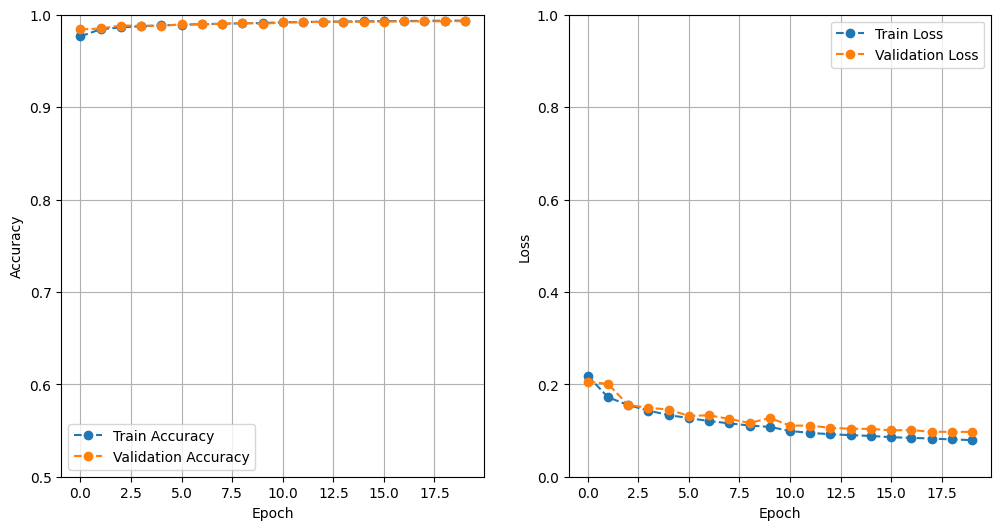

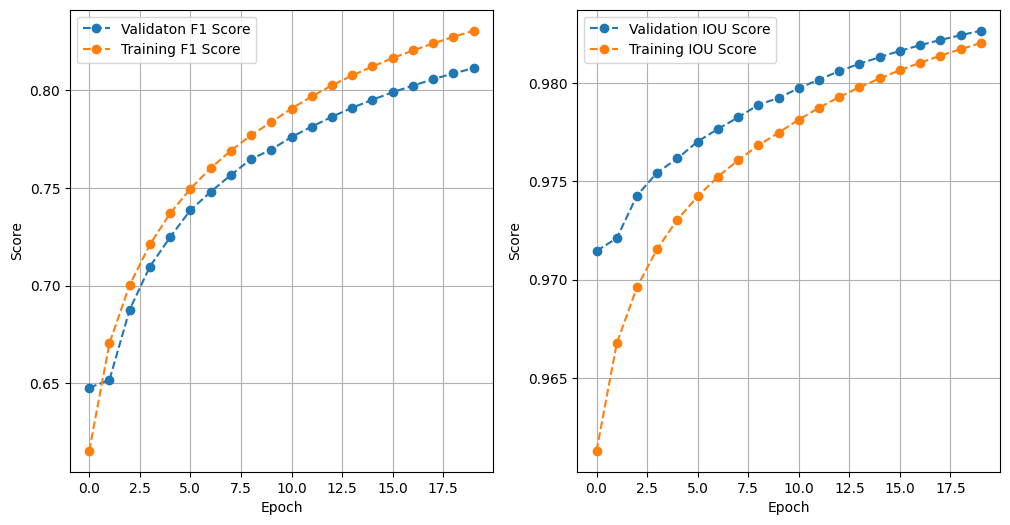

In [ ]:
# %%

if model_training:
    train(
        model,
        images_augmented,
        labels_augmented,
        images_validation,
        labels_validation,
        loss_func=BCEIoULoss(),
        batch_size=4,
        learning_rate=2e-4,
        epochs=20,
        model_validation=model_validation,
        cuda_available=cuda_available,
        path_model=path_model,
    )

if model_loading:
    # Load the model from your Google Drive or local file system
    checkpoint = torch.load(path_model)
    model.load_state_dict(checkpoint["model_state_dict"])

In [ ]:
# %%

submission = submission_creating(
    model, path_testing, training_resize, testing_resize, cuda_available
)

100%|██████████| 5/5 [00:00<00:00,  9.40it/s]


In [ ]:
# %%

np.savetxt("submit.csv", submission, delimiter=",", fmt="%s")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1218894].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0033040235..1.0847623].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0004824306..1.075873].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.1066992].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0760508].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.3341668].


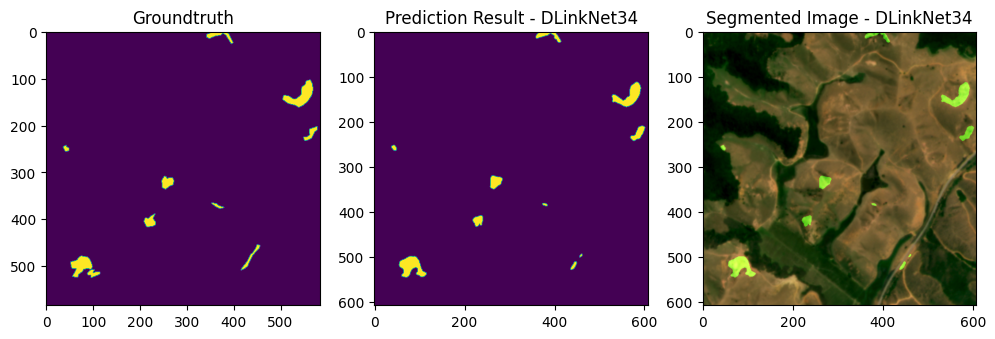

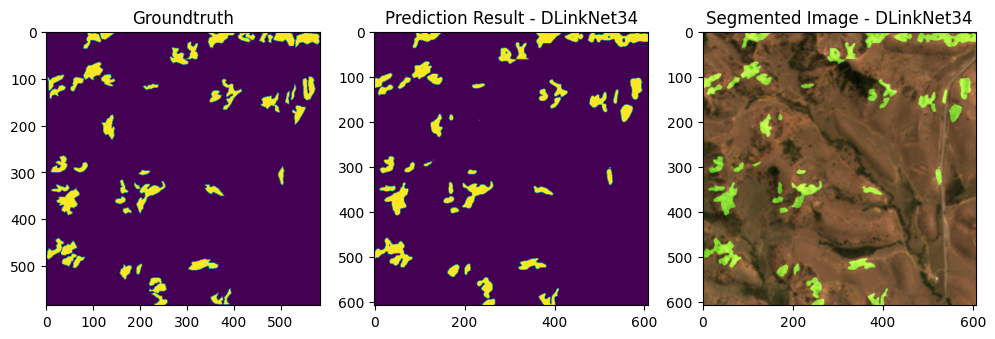

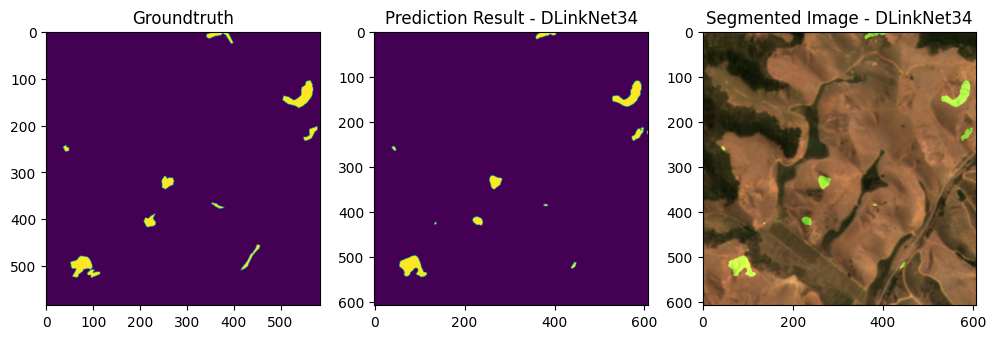

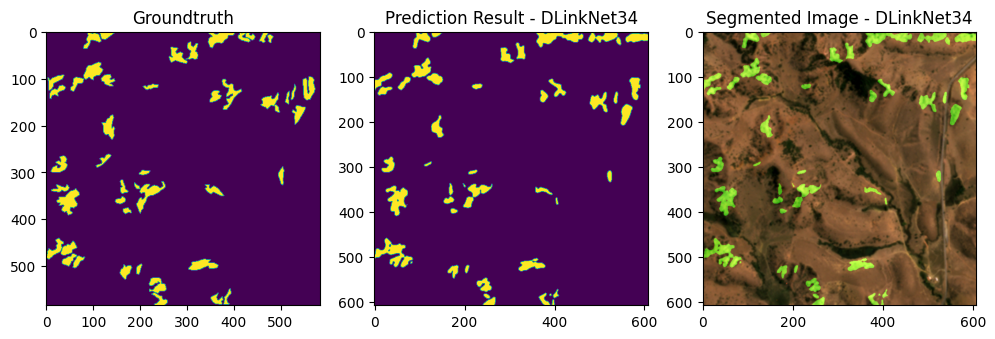

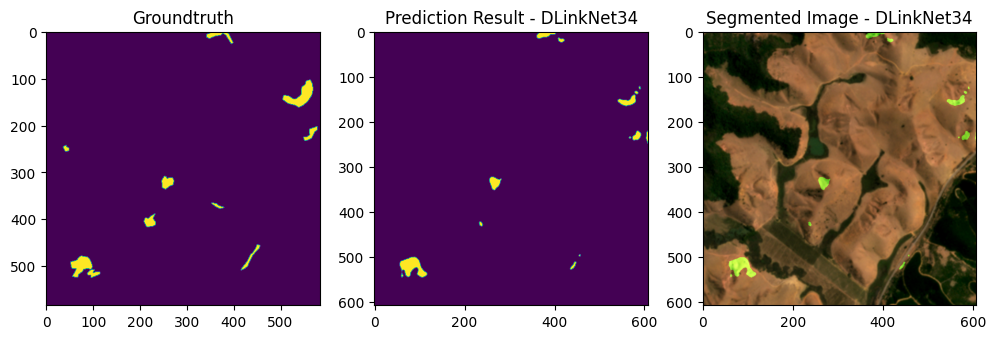

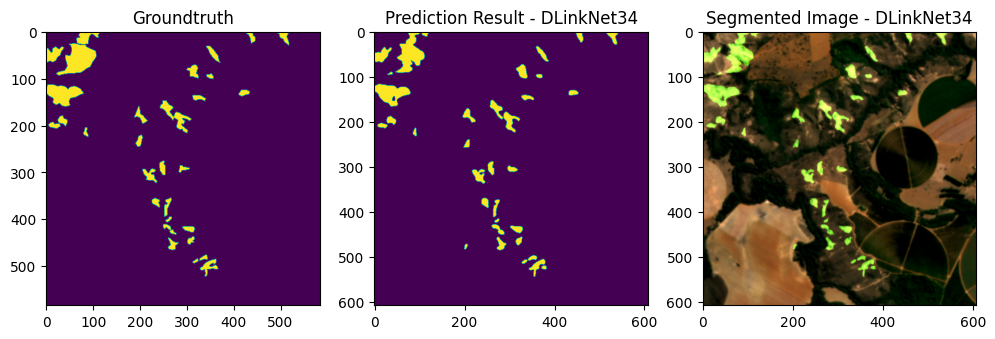

In [ ]:
# %%

for aux in range(747, 753):
    test(path_testing, aux, model, cuda_available)